# Monocle教程
********

## [目录](目录)
[Monocle简介](#Monocle简介)<br>
[环境搭建](#环境搭建)<br>
[1.获取数据](http://staff.washington.edu/hpliner/data/packer_embryo_expression.rds)<br>
[2.数据预处理](#2.数据预处理)<br>
[3.UMAP降维](#3.UMAP降维)<br>
[4.不同基因在不同分支的表达量](#4.不同基因在不同分支的表达量)<br>
[5.细胞聚类](#5.细胞聚类)<br>
[6.寻找主路径](#6.寻找主路径)<br>
[7.对细胞出现的先后进行排序](#7.对细胞出现的先后进行排序)<br>
[8.发育轨迹可视化](#8.发育轨迹可视化)<br>
[9.3D发育轨迹](#9.3D发育轨迹)<br>
[10.差异分析](#10.差异分析)<br>
[11.完整代码](#11.完整代码)<br>
[12.输出文件](#12.输出文件)<br>
[参考文献](#参考文献)<br>
[参考网站](#参考网站)<br>

## Monocle简介
在发育过程中，细胞对刺激作出反应，并在整个生命过程中，从一种功能“状态”过渡到另一种功能“状态”。不同状态的细胞表达不同的基因，产生蛋白质和代谢物的动态重复序列，从而完成它们的工作。当细胞在状态之间移动时，它们经历一个转录重组的过程，一些基因被沉默，另一些基因被激活。这些瞬时状态通常很难描述，因为在更稳定的端点状态之间纯化细胞可能是困难的或不可能的。单细胞RNA-Seq可以使我们在不需要纯化的情况下看到这些状态。然而，要做到这一点，我们必须确定每个cell在可能的状态范围内的位置。

Monocle介绍了利用RNA-Seq进行单细胞轨迹分析的策略。Monocle不是通过实验将细胞纯化成离散状态，而是使用一种算法来学习每个细胞必须经历的基因表达变化序列，作为动态生物学过程的一部分。一旦它了解了基因表达变化的整体“轨迹”，Monocle就可以将每个细胞置于轨迹中的适当位置。如果这个过程有多个结果，Monocle将建立一个“分支”轨迹。

## 环境搭建
<br><font color="red">📌注意：安装相关的依赖包以及R包“monocle3”时注意R语言的版本最好在4.0以上。</font> <br>

In [ ]:
BiocManager::install(c('BiocGenerics', 'DelayedArray', 'DelayedMatrixStats',
                      'limma', 'S4Vectors', 'SingleCellExperiment',
                      'SummarizedExperiment', 'batchelor'))

#install.packages("devtools")

devtools::install_github('cole-trapnell-lab/leidenbase')

devtools::install_github('cole-trapnell-lab/monocle3')

library(monocle3)

package.version(monocle3)

library(louvain)

library(dplyr)

>📰扩展阅读：<br>
> 1) [monocle3 的安装](https://www.jianshu.com/p/79886c1affe5) <br>

<h2 id="1">1.获取数据</h2>

创建对象一共需要三个文件：  
+ expression_matrix ：一个行为基因，列为细胞的基因表达矩阵。  
+ cell_metadata ：一个数据框，行为细胞，列是细胞的属性（比如细胞类型、培养环境、培养时间等）。  
+ gene_metadata是一个数据框，行为feature信息（比如基因），列是基因属性（比如GC含量）。重要的是，这个数据框中必须有这么一列：gene_short_name，其中保存基因名（简称或Symbol标准名均可，用于作图）。  

三个文件要满足并且要满足：expression_matrix的行与gene_metadata的行对应；expression_matrix的列与cell_metadata的行对应。


In [ ]:
#下载数据
expression_matrix = readRDS(url("http://staff.washington.edu/hpliner/data/packer_embryo_expression.rds"))
cell_metadata = readRDS(url("http://staff.washington.edu/hpliner/data/packer_embryo_colData.rds"))
gene_annotation = readRDS(url("http://staff.washington.edu/hpliner/data/packer_embryo_rowData.rds"))

# 创建CDS(Cell Data Set)对象
cds <- new_cell_data_set(expression_matrix,
                         cell_metadata = cell_metadata,
                         gene_metadata = gene_annotation)
cds

>📰扩展阅读：<br>
> 1) [使用monocle做单细胞谱系发育](https://zhuanlan.zhihu.com/p/111921087) <br>

<h2 id="2">2.数据预处理</h2>

这一步就是对数据进行归一化、标准化，初步降维是使用PCA（针对标准的RNA-seq，需要指定计算的主成分数）还是LSA（Latent semantic analysis，针对ATAC-seq），这些都是为后面的聚类操作（tSNE、UMAP做准备）。  
降维方法method = c("PCA", "LSI")，默认是PCA；默认维度num_dim是50；初步降维前归一化norm_method 默认是log处理；设置降维方法是PCA时，自动进行标准化处理。

In [ ]:
# 设置100个主成分，因为细胞数太多(4万多个)，成分太少不足以代表整体
cds <- preprocess_cds(cds, num_dim = 100, residual_model_formula_str = "~ bg.300.loading + bg.400.loading + bg.500.1.loading + bg.500.2.loading + bg.r17.loading + bg.b01.loading + bg.b02.loading")

<h2 id="3">3.UMAP降维</h2>

In [ ]:
cds <- reduce_dimension(cds)
#查看降维后的效果
plot_cells(cds, label_groups_by_cluster=FALSE,  color_cells_by = "cell.type")

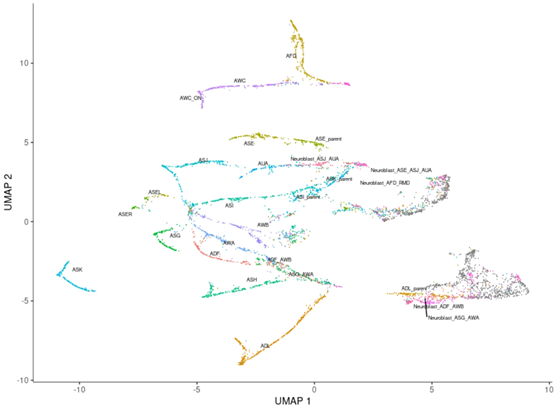

<h2 id="4">4.不同基因在不同分支的表达量</h2>
这一步可以选择不同的gene，然后在UMAP降维图上看每个基因的分布情况。

In [ ]:
ciliated_genes = c("che-1",
                   "hlh-17",
                   "nhr-6",
                   "dmd-6",
                   "ceh-36",
                   "ham-1")
 
plot_cells(cds,
           genes=ciliated_genes,
           label_cell_groups=FALSE,
           show_trajectory_graph=FALSE)

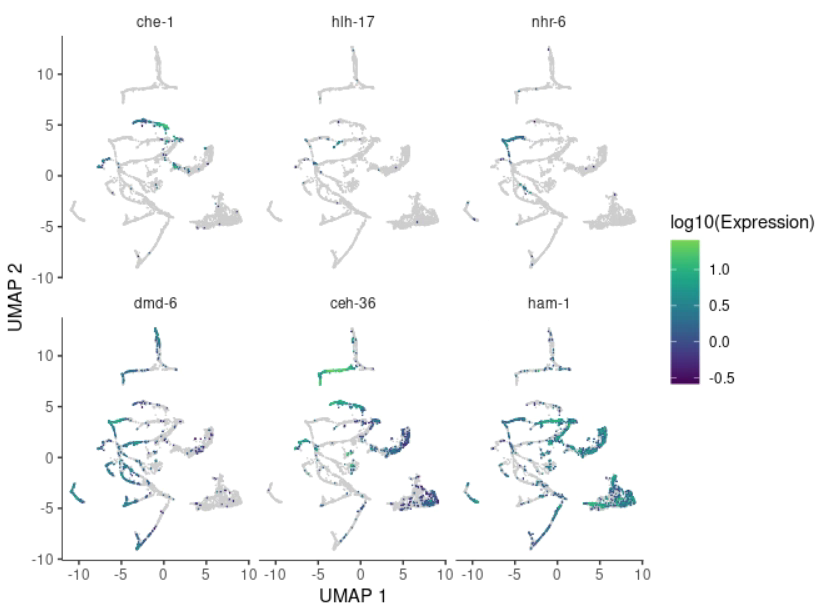

<h2 id="5">5.细胞聚类</h2>

Monocle不认为一组数据中的所有细胞都来自同一个”祖先“，很多实验中，它们会有多个发育轨迹。Monocle会通过聚类来判断细胞是否应该归属同一个发育轨迹。**在monocle的的cluster_cells()中，细胞可以按cluster细分，还可以按partition归为大类。**

In [ ]:
# 这里就用partition聚类
cds <- cluster_cells(cds)

plot_cells(cds, color_cells_by = "partition")

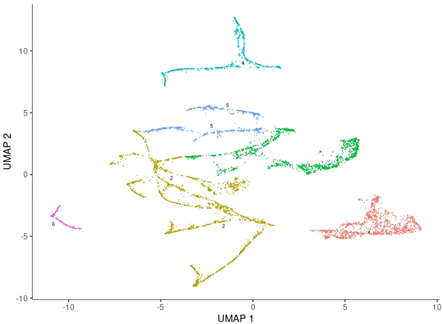

>📰扩展阅读：<br>
> 1) [Monocle包的使用方法](https://www.jianshu.com/p/8131e78c404d) <br>

<h2 id="6">6.寻找主路径</h2>


Monocle3的目的是在实验中了解细胞是如何通过一个基因表达变化的生物程序进行转化的。每个细胞都可以看作是高维空间中的一个点，每个维描述了不同基因的表达。识别基因表达变化的程序相当于学习细胞在这个空间中遵循的轨迹。然而，分析中维度越多，学习轨迹就越困难。  

幸运的是，许多基因通常彼此共存，因此可以使用各种不同的算法来降低数据的维数。Monocle3通过reduce_dimension提供了两种不同的降维算法(UMAP和tSNE)。两者都使用cell_data_set对象和一些允许用于缩小空间的维度。我们还可以提供一个模型公式，指示从数据中“减去”的一些变量(例如批ID或其他技术因素)，这样它就不会对轨迹产生影响。  

函数learn_graph是继preprocess_cds、reduce_dimensions和cluster_cells之后的轨迹构建过程的第四个步骤。用learn graph在每个partition中寻找主路径，即细胞发展的轨迹。

In [ ]:
cds <- learn_graph(cds)
plot_cells(cds,
           color_cells_by = "cell.type",
           label_groups_by_cluster=FALSE,
           label_leaves=FALSE,
           label_branch_points=FALSE)

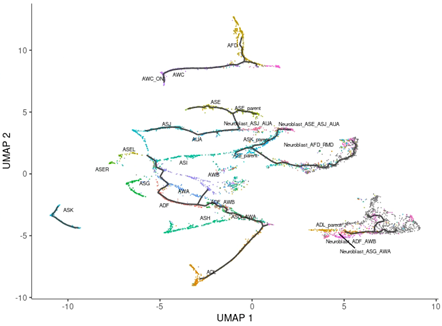

<h2 id="7">7.对细胞出现的先后进行排序</h2>
也就是pseudotime（拟时序分析），推断哪个细胞先出来，哪个细胞后出来。它会对每个细胞在特定的过程（比如分化过程）中的参与度进行评估。

In [ ]:
plot_cells(cds,
           color_cells_by = "embryo.time.bin",
           label_cell_groups=FALSE,
           label_leaves=TRUE,
           label_branch_points=TRUE,
           graph_label_size=1.5)

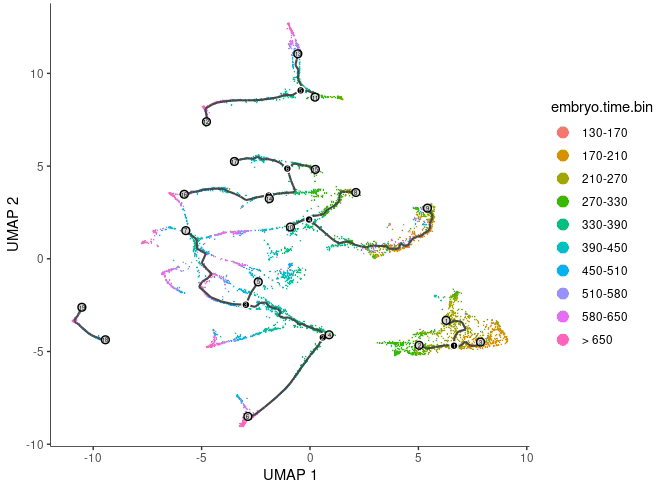

图中的黑线就是整个架构（注意到整个图并非完全连接的，毕竟是按照partition聚类，每个partition中的细胞差异有点大）；浅灰色的圆圈表示”叶片“表示发育轨迹中的不同结局（可以认为拟时序分析的图是一个”根-茎-叶“结构），用参数label_leaves控制；黑色的圆圈表示分支节点，预示着其中的细胞会有不同发展方向，用参数label_branch_points控制；圈中数字大小表示出现时间的先后。  
	从上面的图中我们就能知道出现时间比较早的细胞位置，我们需要对全部的细胞都排个先后顺序，因此要用到order_cells() ，不过这个函数需要一个”根节点“位置，一般是一个partition分配一个根节点。可以通过get_earliest_principal_node()确定根节点：首先根据轨迹图中的节点将与它们最相近的细胞分成组，然后计算来自最早时间点的细胞所占组分，最后挑出包含早期细胞数量最多的节点，认为它是就是根节点。


In [ ]:
# 官方给出了一个函数，这里定义了一个time_bin，选择了最早的时间点区间。
get_earliest_principal_node <- function(cds, time_bin="130-170"){
  # 首先找到出现在最早时间区间的细胞ID
  cell_ids <- which(colData(cds)[, "embryo.time.bin"] == time_bin)
 
  closest_vertex <-
    cds@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex
  closest_vertex <- as.matrix(closest_vertex[colnames(cds), ])
  root_pr_nodes <-
    igraph::V(principal_graph(cds)[["UMAP"]])$name[as.numeric(names
      (which.max(table(closest_vertex[cell_ids,]))))]
 
  root_pr_nodes
}
cds = order_cells(cds, root_pr_nodes=get_earliest_principal_node(cds))

<h2 id="8">8.发育轨迹可视化</h2>
对发育轨迹可视化。

In [ ]:
plot_cells(cds,
           color_cells_by = "pseudotime",
           label_cell_groups=FALSE,
           label_leaves=FALSE,
           label_branch_points=FALSE,
           graph_label_size=1.5)

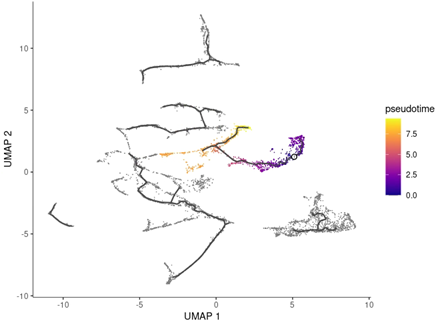

>📰扩展阅读：<br>
> 1) [使用monocle包进行pseudotime分析](https://blog.csdn.net/weixin_43569478/article/details/108079347) <br>

<h2 id="9">9.3D发育轨迹</h2>

In [ ]:
#Working with 3D trajectories

cds_3d = reduce_dimension(cds, max_components = 3)
cds_3d = cluster_cells(cds_3d)
cds_3d = learn_graph(cds_3d)
cds_3d = order_cells(cds_3d, root_pr_nodes=get_earliest_principal_node(cds))

cds_3d_plot_obj = plot_cells_3d(cds_3d, color_cells_by="assigned_cell_type")
cds_3d_plot_obj

📌注意：只能在Rstudio里面才可以显示3D轨迹。

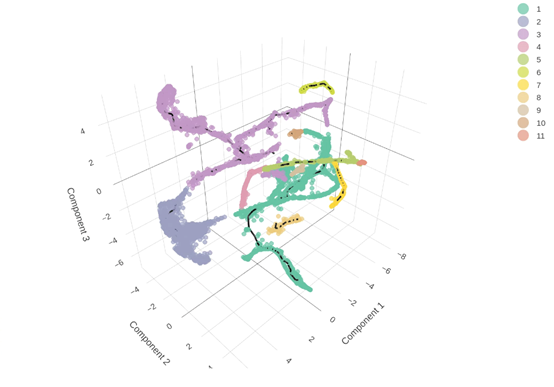

<h2 id="10">10.差异分析</h2>

这一部分将会根据几种不同的标准进行差异分析，并且不同复杂程度的分析用时也有较大差别（几分钟甚至几小时）。本例只针对一小部分基因进行最简单的分析，但实际上它可以处理上千基因。

>📰扩展阅读：<br>
> 1) [scRNA-seq数据分析 || Monocle3
](https://www.jianshu.com/p/e94cff521ebc) <br>

In [ ]:
#测试的小基因集
ciliated_genes = c("che-1",
                   "hlh-17",
                   "nhr-6",
                   "dmd-6",
                   "ceh-36",
                   "ham-1")
cds_subset = cds[rowData(cds)$gene_short_name %in% ciliated_genes,]

Monocle会对每个基因拟合一个回归模型，其中会加入实验中的一些因素（比如时间、处理等）。例如，在胚胎相关的单细胞数据中，细胞会在不同的时间点进行收集，这里就可以检测是否有基因在这段时间内的表达量发生了变化，利用fit_models。

In [ ]:
gene_fits = fit_models(cds_subset, model_formula_str = "~embryo.time")
# 其中model_formula_str就是要比较的分组对象，如果相获得不同的cluster或者partition的差异基因，就用model_formula_str = "~cluster"或者model_formula_str = "~partition"；另外还支持添加多个变量，比如考虑到批次效应 model_formula_str = "~embryo.time + batch"

gene_fits是一个包含每个基因一行的tibble。模型列包含广义线性模型对象，每个模型对象都旨在使用上面的方程解释基因在细胞间的表达。参数model_formula a_str应该是指定模型公式的字符串。我们在测试中使用的模型公式可以包含colData表中作为列存在的任何术语，包括Monocle在其他分析步骤中添加的那些列。例如，如果使用cluster_cells，我们就可以使用cluster或partition(分别)作为模型公式来测试集群和分区之间不同的基因。我们还可以包含多个变量，例如~胚。时间+批处理，这对于减去不需要的partition效果非常有用。

然后我们可以看看哪些基因是与时间因素相关的。

In [ ]:
fit_coefs = coefficient_table(gene_fits)
# 挑出时间相关的组分
emb_time_terms = fit_coefs %>% filter(term == "embryo.time")
# coefficient_table()默认使用 Benjamini and Hochberg（BH）方法进行了p值的校正，得到了q值
emb_time_terms %>% filter (q_value < 0.05) %>%
  select(gene_short_name, term, q_value, estimate)

画出小提琴图

In [ ]:
plot_genes_violin(cds_subset, group_cells_by="embryo.time.bin", ncol=2) +
    theme(axis.text.x=element_text(angle=45, hjust=1))

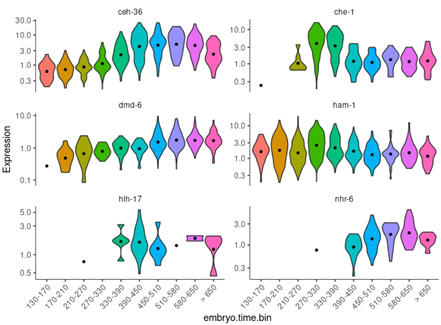

考虑批次效应  
fit_models函数为cell_data_set中的每个基因拟合一个广义线性模型。可以提供公式来说明额外的协变量（例如收集天数、细胞类型、培养条件等）。

In [ ]:
gene_fits = fit_models(cds_subset, model_formula_str = "~embryo.time + batch")
fit_coefs = coefficient_table(gene_fits)
fit_coefs %>% filter(term != "(Intercept)") %>%
  select(gene_short_name, term, q_value, estimate)

模型评价

In [ ]:
gene_fits = fit_models(cds_subset, model_formula_str = "~embryo.time")
evaluate_fits(gene_fits)

使用compare_models()比较判断要不要考虑批次效应，结果会返回一个likelihood ratio test结果

In [ ]:
time_batch_models = fit_models(cds_subset,
                               model_formula_str = "~embryo.time + batch",
                               expression_family="negbinomial")
time_models = fit_models(cds_subset,
                        model_formula_str = "~embryo.time",
                        expression_family="negbinomial")
compare_models(time_batch_models, time_models) %>% select(gene_short_name, q_value)

<h2 id="11">11.完整代码</h2>

In [ ]:
#下载数据
expression_matrix = readRDS(url("http://staff.washington.edu/hpliner/data/packer_embryo_expression.rds"))
cell_metadata = readRDS(url("http://staff.washington.edu/hpliner/data/packer_embryo_colData.rds"))
gene_annotation = readRDS(url("http://staff.washington.edu/hpliner/data/packer_embryo_rowData.rds"))

# 创建CDS(Cell Data Set)对象
cds <- new_cell_data_set(expression_matrix,
                         cell_metadata = cell_metadata,
                         gene_metadata = gene_annotation)
cds

#umap降维
# 设置100个主成分，因为细胞数太多(4万多个)，成分太少不足以代表整体
cds <- preprocess_cds(cds, num_dim = 100, residual_model_formula_str = "~ bg.300.loading + bg.400.loading + bg.500.1.loading + bg.500.2.loading + bg.r17.loading + bg.b01.loading + bg.b02.loading")

cds <- reduce_dimension(cds)
#查看降维后的效果
plot_cells(cds, label_groups_by_cluster=FALSE,  color_cells_by = "cell.type")

ciliated_genes = c("che-1",
                   "hlh-17",
                   "nhr-6",
                   "dmd-6",
                   "ceh-36",
                   "ham-1")
 
plot_cells(cds,
           genes=ciliated_genes,
           label_cell_groups=FALSE,
           show_trajectory_graph=FALSE)

#细胞聚类
# 这里就用partition聚类
cds <- cluster_cells(cds)
plot_cells(cds, color_cells_by = "partition")

#寻找主路径
cds <- learn_graph(cds)
plot_cells(cds,
           color_cells_by = "cell.type",
           label_groups_by_cluster=FALSE,
           label_leaves=FALSE,
           label_branch_points=FALSE)

#细胞出现前后排序
plot_cells(cds,
           color_cells_by = "embryo.time.bin",
           label_cell_groups=FALSE,
           label_leaves=TRUE,
           label_branch_points=TRUE,
           graph_label_size=1.5)

#轨迹可视化
plot_cells(cds,
           color_cells_by = "pseudotime",
           label_cell_groups=FALSE,
           label_leaves=FALSE,
           label_branch_points=FALSE,
           graph_label_size=1.5)

#3D发育轨迹
cds_3d = reduce_dimension(cds, max_components = 3)
cds_3d = cluster_cells(cds_3d)
cds_3d = learn_graph(cds_3d)
cds_3d = order_cells(cds_3d, root_pr_nodes=get_earliest_principal_node(cds))

cds_3d_plot_obj = plot_cells_3d(cds_3d, color_cells_by="assigned_cell_type")
cds_3d_plot_obj

#测试的小基因集
ciliated_genes = c("che-1",
                   "hlh-17",
                   "nhr-6",
                   "dmd-6",
                   "ceh-36",
                   "ham-1")
cds_subset = cds[rowData(cds)$gene_short_name %in% ciliated_genes,]
gene_fits = fit_models(cds_subset, model_formula_str = "~embryo.time")
# 其中model_formula_str就是要比较的分组对象，如果相获得不同的cluster或者partition的差异基因，就用model_formula_str = "~cluster"或者model_formula_str = "~partition"；另外还支持添加多个变量，比如考虑到批次效应 model_formula_str = "~embryo.time + batch"

#与时间相关的gene
fit_coefs = coefficient_table(gene_fits)
# 挑出时间相关的组分
emb_time_terms = fit_coefs %>% filter(term == "embryo.time")
# coefficient_table()默认使用 Benjamini and Hochberg（BH）方法进行了p值的校正，得到了q值
emb_time_terms %>% filter (q_value < 0.05) %>%
  select(gene_short_name, term, q_value, estimate)

#画出小提琴图
plot_genes_violin(cds_subset, group_cells_by="embryo.time.bin", ncol=2) +
    theme(axis.text.x=element_text(angle=45, hjust=1))

#批次效应
gene_fits = fit_models(cds_subset, model_formula_str = "~embryo.time + batch")
fit_coefs = coefficient_table(gene_fits)
fit_coefs %>% filter(term != "(Intercept)") %>%
  select(gene_short_name, term, q_value, estimate)

#模型评价
gene_fits = fit_models(cds_subset, model_formula_str = "~embryo.time")
evaluate_fits(gene_fits)

#是否要考虑批次效应
time_batch_models = fit_models(cds_subset,
                               model_formula_str = "~embryo.time + batch",
                               expression_family="negbinomial")
time_models = fit_models(cds_subset,
                        model_formula_str = "~embryo.time",
                        expression_family="negbinomial")
compare_models(time_batch_models, time_models) %>% select(gene_short_name, q_value)

## 12.输出文件

| 步骤 | 输出文件 | 文件作用 |
 :-: | :-: | :-:
| 聚类 | cds/clusters/listData/UMAP/clusters ; cds/clusters/listData/UMAP/patitions |小类聚类结果 ；大类聚类结果 |

📌注意：伪时间序列不可以直接从monocle对象中抽离出来，参考回答[How to extract pseudotime coordinates (components) for each cell?](https://github.com/cole-trapnell-lab/monocle-release/issues/356)可以单独得到伪时间序列。Monocle输出的只有一个Monocle对象，可以在R当中直接查看需要的图片和对应的信息。

## 参考文献
[1] [Trapnell, C., et al. (2014). "The dynamics and regulators of cell fate decisions are revealed by pseudotemporal ordering of single cells." Nature Biotechnology 32(4): 381-386.](https://www.nature.com/articles/nbt.2859)

## 参考网站
[1] [Monocle-拟时分析pseudotime的理解](https://www.jianshu.com/p/be6102f77203)  
[2] [scRNA-seq数据分析Monocle3](https://www.jianshu.com/p/e94cff521ebc)  
[3] [单细胞分析十八般武艺5：monocle3](https://cloud.tencent.com/developer/article/1819550)  
[4] [跟着官网学习单细胞Monocle3](https://www.plob.org/article/20919.html)  
[5] [使用Monocle3对多样本单细胞数据进行伪时间分析](https://jddian.xyz/Monocle3/)  